# Initialization

In [1]:
import nest_asyncio
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
import os
import pickle
from openai import OpenAI
from dotenv import load_dotenv
from nodes import network_gathering_node, graph_and_exploitation_inference_node, exposure_manager_node, event_summarizer_node, firewall_node, save_iteration_node, node_utils
from configuration.state import HoneypotStateReact
from configuration import memory
from prompts import firewall_executor_prompt
nest_asyncio.apply()
import benchmark.benchmark as b


def display_graph(graph, width=300, height=300):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=node_utils.OPEN_AI_KEY)
        response = client.chat.completions.create(
            model="gpt-4.1",
            messages=[{"role":"system", "content":"ciao"}],
            )
        print(response.choices[0].message.content)
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [2]:
# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ciao! Come posso aiutarti oggi?
API key is valid: True


In [3]:
def should_continue_from_firewall(state: HoneypotStateReact) -> Literal["tools_firewall", "persistence_node"]:
    if hasattr(state, 'firewall_action'):
        return "tools_firewall"
    
    return "persistence_node"

In [4]:
def build_graph():
    graph = StateGraph(HoneypotStateReact)
    
    graph.add_node("network_gathering", network_gathering_node.network_gathering)
    graph.add_node("event_summarizer", event_summarizer_node.event_summarizer)
    graph.add_node("graph_and_exploitation_inference", graph_and_exploitation_inference_node.graph_and_exploitation_inference)
    graph.add_node("exposure_manager", exposure_manager_node.exposure_manager)
    graph.add_node("firewall_manager", firewall_node.firewall_executor)
    graph.add_node("persistence_node", save_iteration_node.save_iteration)
    graph.add_node("tools_firewall", firewall_node.tools_firewall)
 

    # Define execution order
    graph.add_edge(START, "network_gathering")
    graph.add_edge("network_gathering", "event_summarizer") 
    graph.add_edge("event_summarizer", "graph_and_exploitation_inference")
    graph.add_edge("graph_and_exploitation_inference", "exposure_manager")
    graph.add_edge("exposure_manager", "firewall_manager")
    graph.add_conditional_edges("firewall_manager", should_continue_from_firewall)
    graph.add_edge("tools_firewall", "persistence_node")
    graph.add_edge("persistence_node", END)

        
    return graph.compile()

def build_graph_test():
    graph = StateGraph(HoneypotStateReact)
    
    graph.add_node("network_gathering", network_gathering_node.network_gathering)
    graph.add_node("event_summarizer", event_summarizer_node.event_summarizer)
    

    # Define execution order
    graph.add_edge(START, "network_gathering")
    graph.add_edge("network_gathering", "event_summarizer") 
    graph.add_edge("event_summarizer", END)

        
    return graph.compile()

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:60977/devtools/browser/d218e914-20ed-49e9-acf5-bc9e368039bf
INFO:pyppeteer.launcher:terminate chrome process...


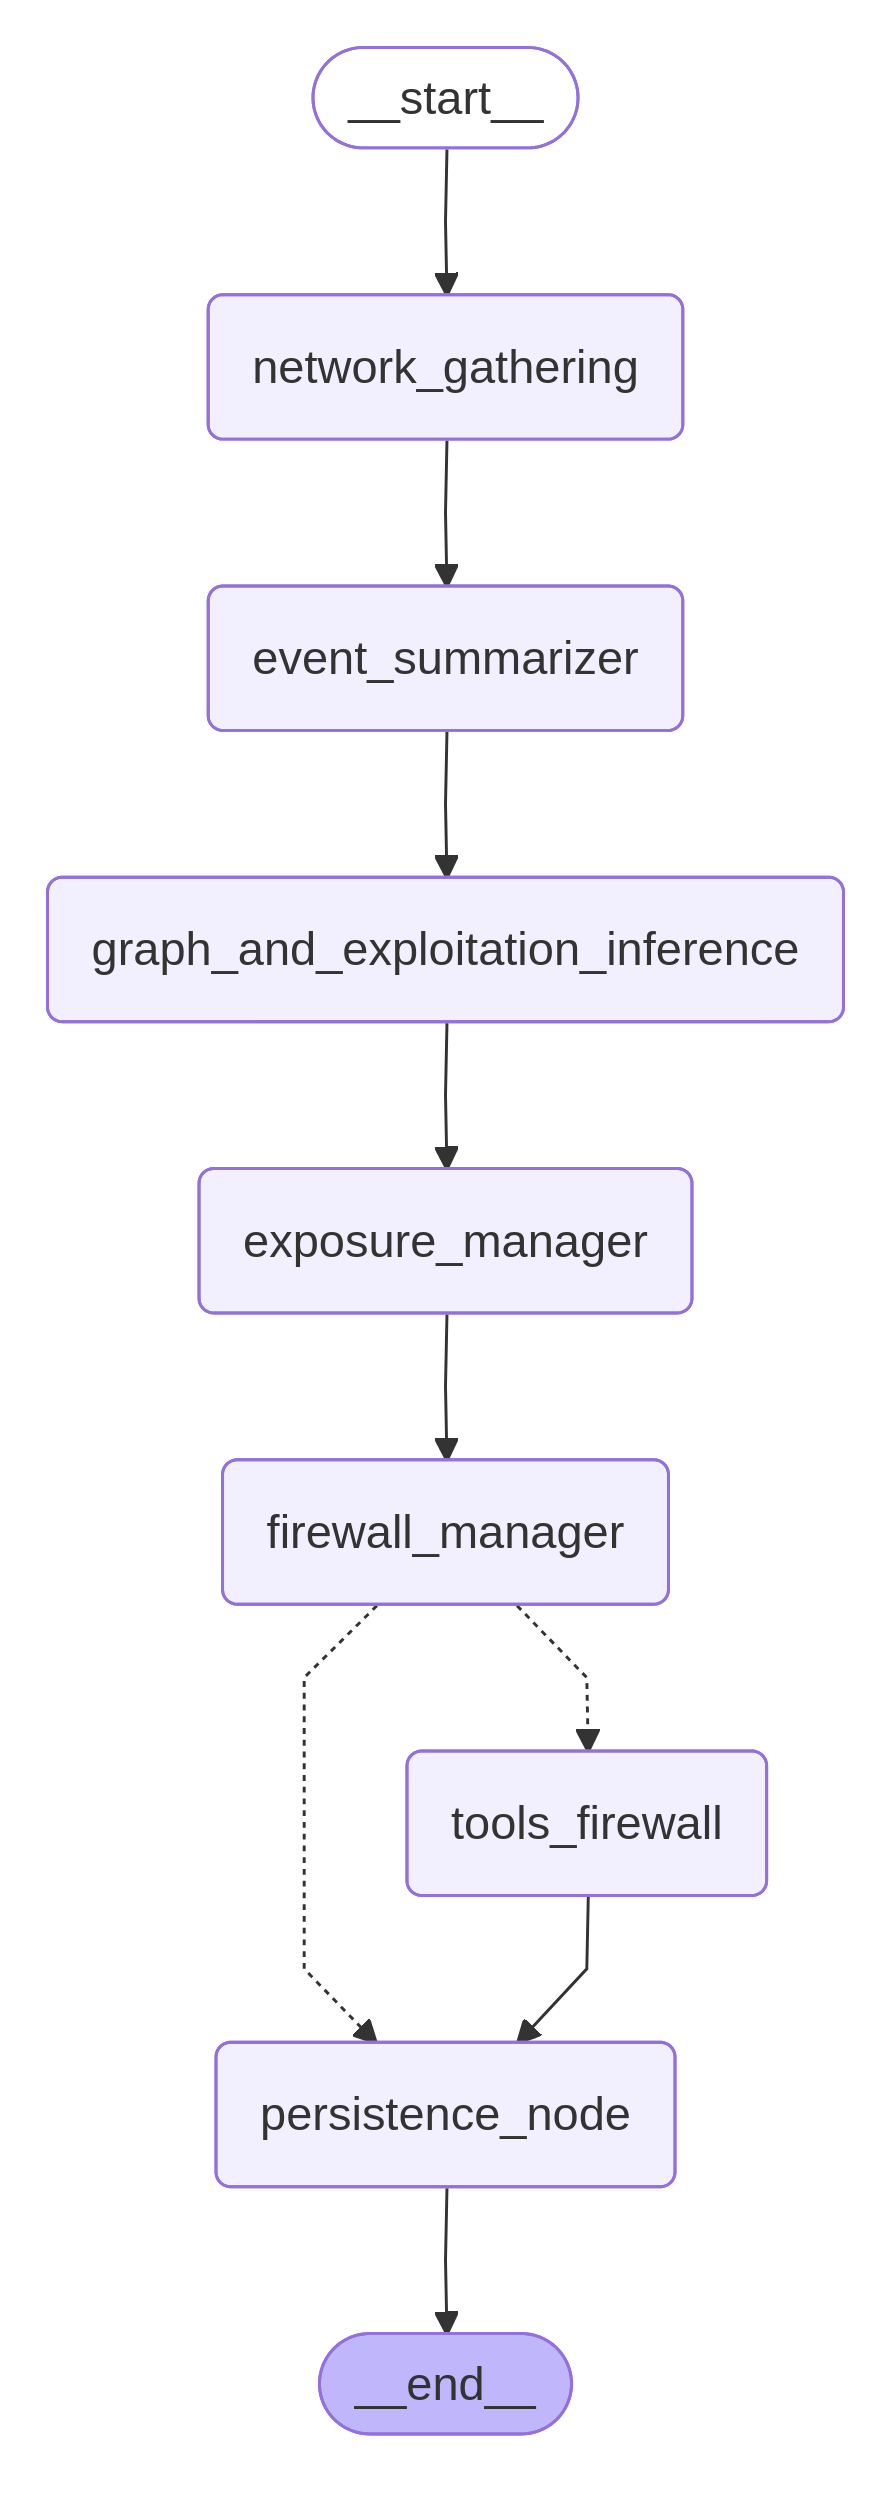

In [5]:
graph = build_graph()
# graph = build_graph_test()
display_graph(graph)

## Single Iteration

In [6]:
# episodic_memory = memory.EpisodicMemory()

In [7]:
# responses = []
# for i in range(2):
#     initial_state = HoneypotStateReact(
#         messages=[]
#     )
#     response = await graph.ainvoke(initial_state, config={"configurable": {"store" : episodic_memory, "prompt":"eve", "time_window":2, "epoch_num":i+1, "model_config":"small:4.1"}})
#     responses.append(response)

In [8]:
# for response in responses:
#     for m in response['messages']:
#         m.pretty_print()

# Benchmark

In [10]:
episodic_memory = memory.EpisodicMemory()
dir_name = "test_1"

config_dict = {
            "max_epochs": 15,
            "attack_duration": 240,
            "monitor_accumulation_wait": 10,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": dir_name
        }
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages=[]
)
responses = []
async def my_agent_executor(epoch_num: int):
    response = await graph.ainvoke(initial_state, config={
        "configurable": 
            {
            "store" : episodic_memory, 
            "time_window":2, 
            "prompt":"eve",
            "epoch_num": epoch_num,
            "model_config": "small:4.1"
            }
        }
    )
    responses.append(response)
    return response
    

results = runner.run(my_agent_executor)
with open(f"./benchmark/benchmark_results/{dir_name}/responses.pkl", "wb") as f:
    pickle.dump(responses, f)


INFO:benchmark.benchmark.Orchestrator:Starting benchmark run
INFO:benchmark.benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.benchmark.Orchestrator:
INFO:benchmark.benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.benchmark.Orchestrator:============================================================

INFO:benchmark.benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.benchmark.Orchestrator:Starting attacker script with a fallback timeout of 240s...
INFO:benchmark.benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] [

KeyboardInterrupt: 

# Printing Responses

In [ ]:
for i, response in enumerate(responses):
    
    print("=" * 130)
    print(f"Epoch: {i+1}")
    for m in response['messages']:
        m.pretty_print()
    print("-" * 130)

Epoch: 1
================================ Human Message =================================

{'alerts': [], 'time_window_minutes': 2, 'timestamp': '2025-10-15T18:29:45.204334Z', 'total_events': 0}
================================== Ai Message ==================================

No alerts retrieved
================================== Ai Message ==================================

Reasoning: no updates in delta; returning previous graph unchanged
Inferred Attack Graph: {'edges': [], 'interesting': []}
Honeypot Exploitation: [{'ip': '172.20.0.10', 'service': 'cve-2021-22205-gitlab-1-proxy', 'level_prev': 0, 'level_new': 0, 'changed': False, 'evidence_quotes': []}, {'ip': '172.20.0.3', 'service': 's2-057-struts2-1', 'level_prev': 0, 'level_new': 0, 'changed': False, 'evidence_quotes': []}, {'ip': '172.20.0.2', 'service': 'unauthorized-rce-docker-1', 'level_prev': 0, 'level_new': 0, 'changed': False, 'evidence_quotes': []}, {'ip': '172.20.0.7', 'service': 'xdebug-rce-xdebug2-1', 'level_prev': 

In [ ]:
# dir_name = 'test_4'
# with open(f"./benchmark/benchmark_results/{dir_name}/responses.pkl", "rb") as f:
#     saved_responses = pickle.load(f)

# for i, res in enumerate(saved_responses):
#     print(f"Epoch {i+1}")
#     for m in res["messages"]:
#         m.pretty_print()

Epoch 1
================================ Human Message =================================

{'alerts': [{'category': 'Attempted Information Leak', 'dest_ip': '172.20.0.3', 'dest_port': 139, 'flow_id': 1989880810811393, 'payload': None, 'proto': 'TCP', 'severity': 3, 'signature': 'POSSBL PORT SCAN (NMAP -sS)', 'src_ip': '192.168.100.2', 'src_port': 33480, 'timestamp': '2025-10-14T11:49:11.987593+0200'}, {'category': 'Attempted Information Leak', 'dest_ip': '172.20.0.3', 'dest_port': 110, 'flow_id': 243811260725672, 'payload': None, 'proto': 'TCP', 'severity': 3, 'signature': 'POSSBL PORT SCAN (NMAP -sS)', 'src_ip': '192.168.100.2', 'src_port': 33480, 'timestamp': '2025-10-14T11:49:12.187838+0200'}, {'category': 'Attempted Information Leak', 'dest_ip': '172.20.0.2', 'dest_port': 3389, 'flow_id': 259823187724236, 'payload': None, 'proto': 'TCP', 'severity': 3, 'signature': 'POSSBL PORT SCAN (NMAP -sS)', 'src_ip': '192.168.100.2', 'src_port': 33480, 'timestamp': '2025-10-14T11:49:12.388174+0